Notebook to perform predictive modeling

# Setup

In [6]:
import sys
import time

import numpy as np
import pandas as pd
import tensorflow as tf

from keras import backend, models, layers, initializers, regularizers, constraints, optimizers
from keras import callbacks as kc
from keras import optimizers as ko
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score, KFold, train_test_split

In [7]:
proj_path = "/Users/aarontrefler_temp2/Documents/My_Documents/Kaggle/kaggle-gendered-pronoun/"
sys.path.insert(0, proj_path)

In [8]:
import src.utils as utils
import src.data.data_utils as data_utils
import src.models.bert_model_utils as bert_model_utils
import src.models.keras_model_utils as keras_model_utils

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

pd.options.display.max_columns = 20

In [10]:
data_raw_dir = proj_path + "data/raw/"
data_clean_dir = proj_path + "data/clean/"
models_dir = proj_path + "models/"

# Read in Features and Labels

In [11]:
X_train = np.genfromtxt(data_clean_dir + "X_train.csv", delimiter=",")
X_valid = np.genfromtxt(data_clean_dir + "X_valid.csv", delimiter=",")
X_test = np.genfromtxt(data_clean_dir + "X_test.csv", delimiter=",")
X_testS2 = np.genfromtxt(data_clean_dir + "X_testS2.csv", delimiter=",")

Y_train = np.genfromtxt(data_clean_dir + "Y_train.csv", delimiter=",")
Y_valid = np.genfromtxt(data_clean_dir + "Y_valid.csv", delimiter=",")
Y_test = np.genfromtxt(data_clean_dir + "Y_test.csv", delimiter=",")
Y_testS2 = np.genfromtxt(data_clean_dir + "Y_testS2.csv", delimiter=",")

# Neural Network Modeling

In [15]:
dense_layer_sizes = [37]
dropout_rate = 0.6
learning_rate = 0.001
n_fold = 5
batch_size = 32
epochs = 1000
patience = 100
lambd = 0.1 # L2 regularization

In [16]:
# Will train on data from the gap-test and gap-validation files, in total 2454 rows
X = np.concatenate((X_train, X_valid), axis = 0)
Y = np.concatenate((Y_train, Y_valid), axis = 0)

# Will predict probabilities for data from the gap-development file and Kaggle Stage 2
prediction = np.zeros((len(X_test), 3)) # testing predictions
predictionS2 = np.zeros((len(X_testS2), 3)) # kaggle stage 2 predictions

In [17]:
# Training and cross-validation
folds = KFold(n_splits=n_fold, shuffle=True, random_state=3)
scores = []
for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
    # split training and validation data
    print('Fold', fold_n, 'started at', time.ctime())
    X_tr, X_val = X[train_index], X[valid_index]
    Y_tr, Y_val = Y[train_index], Y[valid_index]

    # Define the model, re-initializing for each fold
    classif_model = keras_model_utils.build_mlp_model(
        [X.shape[1]], dense_layer_sizes=dense_layer_sizes, dropout_rate=dropout_rate, lambd=lambd)
    classif_model.compile(optimizer = optimizers.Adam(lr = learning_rate), loss = "categorical_crossentropy")
    callbacks = [kc.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights = True)]

    # train the model
    classif_model.fit(
        x = X_tr, y = Y_tr, 
        epochs = epochs, batch_size = batch_size, callbacks = callbacks, validation_data = (X_val, Y_val), verbose = 0
    )

    # make predictions on validation and testing datasets
    pred_valid = classif_model.predict(x = X_val, verbose = 0)
    pred = classif_model.predict(x=X_test, verbose=0)
    predS2 = classif_model.predict(x=X_testS2, verbose=0) 

    scores.append(log_loss(Y_val, pred_valid))
    
    prediction += pred
    prediction /= n_fold
    
    predictionS2 += predS2
    predictionS2 /= n_fold

# Print CV scores, as well as score on the GAP test data
print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
print(scores)
print("Test score:", log_loss(Y_test, prediction))

Fold 0 started at Thu Apr 18 18:53:50 2019


/Users/aarontrefler_temp2/Documents/My_Documents/Kaggle/kaggle-gendered-pronoun/src/models/keras_model_utils.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in..., name="classif_model")`
  model = models.Model(input = X_input, output = X, name = "classif_model")


Fold 1 started at Thu Apr 18 18:54:06 2019


/Users/aarontrefler_temp2/Documents/My_Documents/Kaggle/kaggle-gendered-pronoun/src/models/keras_model_utils.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in..., name="classif_model")`
  model = models.Model(input = X_input, output = X, name = "classif_model")


Fold 2 started at Thu Apr 18 18:54:22 2019


/Users/aarontrefler_temp2/Documents/My_Documents/Kaggle/kaggle-gendered-pronoun/src/models/keras_model_utils.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in..., name="classif_model")`
  model = models.Model(input = X_input, output = X, name = "classif_model")


Fold 3 started at Thu Apr 18 18:54:38 2019


/Users/aarontrefler_temp2/Documents/My_Documents/Kaggle/kaggle-gendered-pronoun/src/models/keras_model_utils.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in..., name="classif_model")`
  model = models.Model(input = X_input, output = X, name = "classif_model")


Fold 4 started at Thu Apr 18 18:54:54 2019


/Users/aarontrefler_temp2/Documents/My_Documents/Kaggle/kaggle-gendered-pronoun/src/models/keras_model_utils.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in..., name="classif_model")`
  model = models.Model(input = X_input, output = X, name = "classif_model")


CV mean score: 0.5742, std: 0.0398.
[0.5251470587434212, 0.5295418376389222, 0.6221143356761506, 0.5879593659174541, 0.6064720966724907]
Test score: 0.5464821044607627


In [18]:
# Write the prediction to file for submission
submission = pd.read_csv(data_raw_dir + "gendered-pronoun-resolution/sample_submission_stage_2.csv", index_col = "ID")
submission["A"] = predictionS2[:,0]
submission["B"] = predictionS2[:,1]
submission["NEITHER"] = predictionS2[:,2]
submission.to_csv(models_dir + "submissions/submission_stage2_bert.csv")

# Visualize Predictions

In [32]:
df_pred_stage1 = pd.DataFrame(prediction)
df_pred_stage2 = pd.DataFrame(predictionS2)

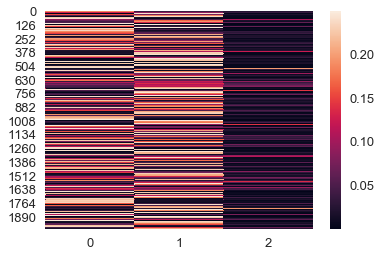

In [35]:
# Stage 1 predictions
sns.heatmap(df_pred_stage1)
plt.show()

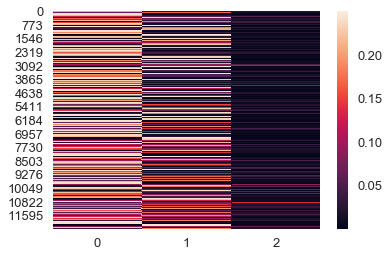

In [36]:
# Stage 2 predictions
sns.heatmap(df_pred_stage2)
plt.show()